In [4]:
from google.colab.patches import cv2_imshow
import numpy as np
import imutils
import time
import cv2
import os 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Inference on Video

In [28]:
def object_detection(input_video, output_video):
  classes = ['D00', 'D10', 'D20', 'D40']
  alt_names = {'D00': 'lateral_crack', 'D10': 'linear_cracks', 'D20': 'aligator_crakcs', 'D40': 'potholes'}
  # initialize a list of colors to represent each possible class label
  np.random.seed(42)
  COLORS = np.random.randint(0, 255, size=(len(classes), 3),
    dtype="uint8")
  # derive the paths to the YOLO weights and model configuration
  weightsPath = "/content/drive/MyDrive/yolo/yolo-obj_final.weights"
  configPath = "/content/yolov3.cfg"
  # load our YOLO object detector trained on COCO dataset (80 classes)
  # and determine only the *output* layer names that we need from YOLO
  print("[INFO] loading YOLO from disk...")
  net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
  ln = net.getLayerNames()
  ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

  # initialize the video stream, pointer to output video file, and
  # frame dimensions
  vs = cv2.VideoCapture(input_video)
  writer = None
  (W, H) = (None, None)
  # try to determine the total number of frames in the video file
  try:
    prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
      else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("[INFO] {} total frames in video".format(total))
  # an error occurred while trying to determine the total
  # number of frames in the video file
  except:
    print("[INFO] could not determine # of frames in video")
    print("[INFO] no approx. completion time can be provided")
    total = -1

  # loop over frames from the video file stream
  while True:
    # read the next frame from the file
    (grabbed, frame) = vs.read()
    # if the frame was not grabbed, then we have reached the end
    # of the stream
    if not grabbed:
      break
    # if the frame dimensions are empty, grab them
    if W is None or H is None:
      (H, W) = frame.shape[:2]

    # construct a blob from the input frame and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes
    # and associated probabilities
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
      swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)
    end = time.time()
    # initialize our lists of detected bounding boxes, confidences,
    # and class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []

    # loop over each of the layer outputs
    for output in layerOutputs:
      # loop over each of the detections
      for detection in output:
        # extract the class ID and confidence (i.e., probability)
        # of the current object detection
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        # filter out weak predictions by ensuring the detected
        # probability is greater than the minimum probability
        if confidence > 0.3:
          # scale the bounding box coordinates back relative to
          # the size of the image, keeping in mind that YOLO
          # actually returns the center (x, y)-coordinates of
          # the bounding box followed by the boxes' width and
          # height
          box = detection[0:4] * np.array([W, H, W, H])
          (centerX, centerY, width, height) = box.astype("int")
          # use the center (x, y)-coordinates to derive the top
          # and and left corner of the bounding box
          x = int(centerX - (width / 2))
          y = int(centerY - (height / 2))
          # update our list of bounding box coordinates,
          # confidences, and class IDs
          boxes.append([x, y, int(width), int(height)])
          confidences.append(float(confidence))
          classIDs.append(classID)

    # apply non-maxima suppression to suppress weak, overlapping
    # bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.3,
      0.25)
    # ensure at least one detection exists
    if len(idxs) > 0:
      # loop over the indexes we are keeping
      for i in idxs.flatten():
        # extract the bounding box coordinates
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        # draw a bounding box rectangle and label on the frame
        color = [int(c) for c in COLORS[classIDs[i]]]
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        label = classes[classIDs[i]]
        text = "{}: {:.4f}".format(alt_names[label],
          confidences[i])
        cv2.putText(frame, text, (x, y - 5),
          cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # cv2.imshow('frame', frame)
    # if cv2.waitKey(25) & 0xFF == ord('q'): 
    #   break
    # check if the video writer is None
    if writer is None:
      # initialize our video writer
      fourcc = cv2.VideoWriter_fourcc(*"MJPG")
      writer = cv2.VideoWriter(output_video, fourcc, 30,
        (frame.shape[1], frame.shape[0]), True)
      # some information on processing single frame
      if total > 0:
        elap = (end - start)
        print("[INFO] single frame took {:.4f} seconds".format(elap))
        print("[INFO] estimated total time to finish: {:.4f}".format(
          elap * total))
    # write the output frame to disk
    writer.write(frame)
  # release the file pointers
  print("[INFO] cleaning up...")
  writer.release()
  vs.release()

In [37]:
object_detection('/content/input.mp4', '/content/result.avi')

[INFO] loading YOLO from disk...
[INFO] 1819 total frames in video
[INFO] single frame took 1.8249 seconds
[INFO] estimated total time to finish: 3319.4144
[INFO] cleaning up...


###Inference on images

In [24]:
def func(input_file):
  classes = ['D00', 'D10', 'D20', 'D40']
  alt_names = {'D00': 'lateral_crack', 'D10': 'linear_cracks', 'D20': 'aligator_crakcs', 'D40': 'potholes'}
  # initialize a list of colors to represent each possible class label
  np.random.seed(42)
  COLORS = np.random.randint(0, 255, size=(len(classes), 3),
    dtype="uint8")
  # derive the paths to the YOLO weights and model configuration
  weightsPath = "/content/drive/MyDrive/yolo/yolo-obj_final.weights"
  configPath = "/content/yolov3.cfg"
  # load our YOLO object detector trained on COCO dataset (80 classes)
  # and determine only the *output* layer names that we need from YOLO
  #print("[INFO] loading YOLO from disk...")
  net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
  ln = net.getLayerNames()
  ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

  
  # read the next frame from the file
  frame = cv2.imread(input_file)
  (H, W) = frame.shape[:2]

  # construct a blob from the input frame and then perform a forward
  # pass of the YOLO object detector, giving us our bounding boxes
  # and associated probabilities
  blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
    swapRB=True, crop=False)
  net.setInput(blob)
  start = time.time()
  layerOutputs = net.forward(ln)
  end = time.time()
  # initialize our lists of detected bounding boxes, confidences,
  # and class IDs, respectively
  boxes = []
  confidences = []
  classIDs = []

  # loop over each of the layer outputs
  for output in layerOutputs:
    # loop over each of the detections
    for detection in output:
      # extract the class ID and confidence (i.e., probability)
      # of the current object detection
      scores = detection[5:]
      classID = np.argmax(scores)
      confidence = scores[classID]
      # filter out weak predictions by ensuring the detected
      # probability is greater than the minimum probability
      if confidence > 0.3:
        # scale the bounding box coordinates back relative to
        # the size of the image, keeping in mind that YOLO
        # actually returns the center (x, y)-coordinates of
        # the bounding box followed by the boxes' width and
        # height
        box = detection[0:4] * np.array([W, H, W, H])
        (centerX, centerY, width, height) = box.astype("int")
        # use the center (x, y)-coordinates to derive the top
        # and and left corner of the bounding box
        x = int(centerX - (width / 2))
        y = int(centerY - (height / 2))
        # update our list of bounding box coordinates,
        # confidences, and class IDs
        boxes.append([x, y, int(width), int(height)])
        confidences.append(float(confidence))
        classIDs.append(classID)

  # apply non-maxima suppression to suppress weak, overlapping
  # bounding boxes
  idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.3,
    0.25)
  # ensure at least one detection exists
  if len(idxs) > 0:
    # loop over the indexes we are keeping
    for i in idxs.flatten():
      # extract the bounding box coordinates
      (x, y) = (boxes[i][0], boxes[i][1])
      (w, h) = (boxes[i][2], boxes[i][3])
      # draw a bounding box rectangle and label on the frame
      color = [int(c) for c in COLORS[classIDs[i]]]
      cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
      label = classes[classIDs[i]]
      text = "{}: {:.4f}".format(alt_names[label],
        confidences[i])
      cv2.putText(frame, text, (x, y - 5),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  cv2_imshow(frame)
  

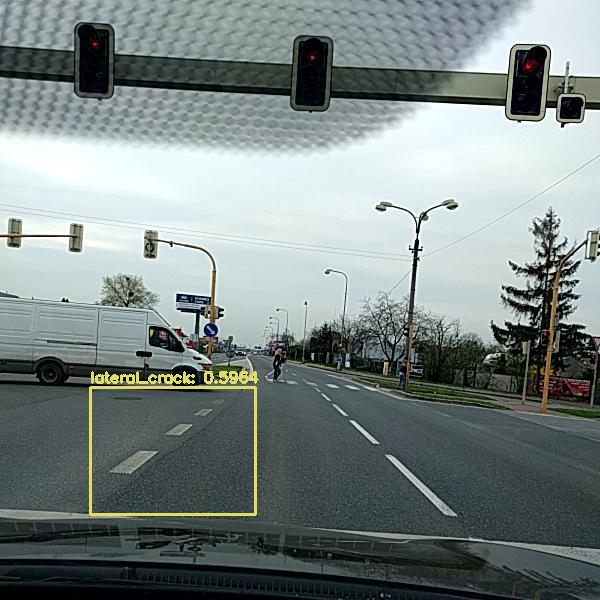

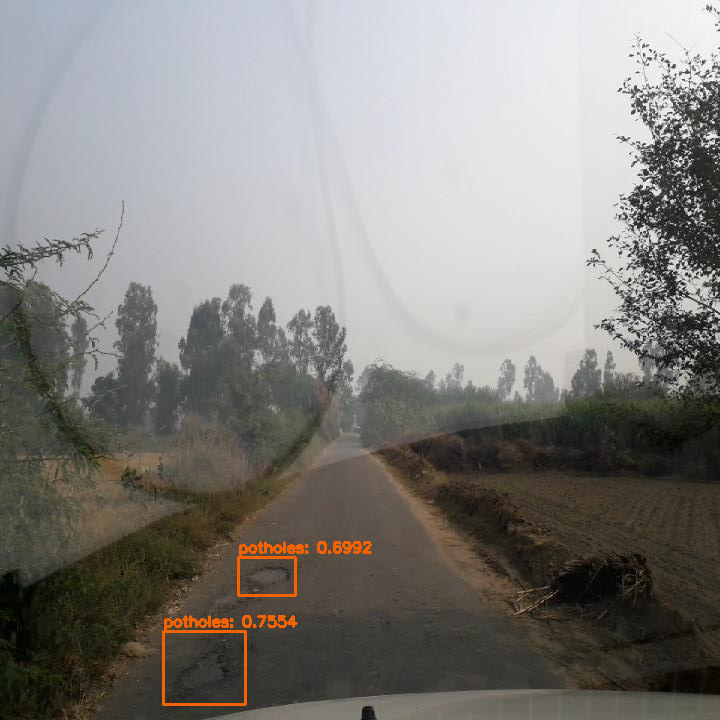

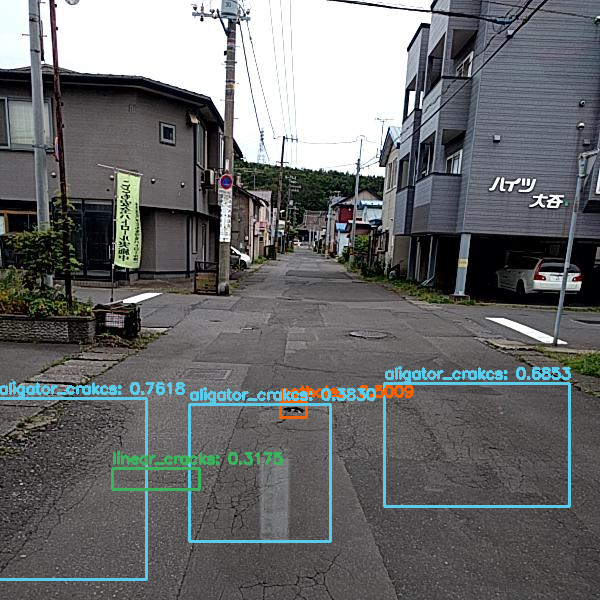

In [27]:
images = ['/content/Czech_003362.jpg','/content/India_002894.jpg','/content/Japan_004720.jpg']
for image in images:
  func(image)